In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#file capture
from glob import glob

#preprocessing and transformation
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

#model
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.utils.validation import check_is_fitted


from ipywidgets import Dropdown, FloatSlider, IntSlider, interact

In [ ]:
#Defining a function wrangle to do the following:
#1. filter the data >400,000 USD for the region CF and the property type as apartment
#2. removed outliers from the size of the apartments to remove skewness
#3. split the lat and long colums
#4. extracted neighborhood and dropped the place_with_parent_names column
def wrangle(filename):

  #read the csv
  df = pd.read_csv(filename)

  #creating the mask filters
  mask_state = df["place_with_parent_names"].str.contains("Capital Federal")
  mask_price = df["price_aprox_usd"] <400000
  mask_apt = df["property_type"] == "apartment"
  df = df[mask_state & mask_apt & mask_price]

  #removing outliers of size
  low,high = df["surface_covered_in_m2"].quantile([0.1,0.9])
  mask_size = df["surface_covered_in_m2"].between(low,high)
  df = df[mask_size]

  #splitting lat and long
  df[["lat","lon"]] = df["lat-lon"].str.split(",", expand = True).astype(float)
  df = df.drop(["lat-lon"],axis=1)

  # getting neighborhood
  df["neighborhood"] = df["place_with_parent_names"].str.split("|",expand=True)[3]
  df = df.drop(["place_with_parent_names"],axis=1)


  #df = df.drop(columns = df.columns[(df.isnull().sum()/len(df)*100) > 50])
  #df = df.drop(["operation","property_type","properati_url","currency"], axis = 1)

  #drop leaky columns
  df = df.drop(["price", "price_aprox_local_currency", "price_per_m2", "price_usd_per_m2"], axis = 1)

  #dropping features with multi collinearity
  #df = df.drop(["surface_total_in_m2", "rooms"],axis = 1)

  return df

In [ ]:
raw_files = glob("/content/drive/MyDrive/Data for WQU/Project 2/buenos-aires-real-estate-*.csv")
raw_files

['/content/drive/MyDrive/Data for WQU/Project 2/buenos-aires-real-estate-1.csv',
 '/content/drive/MyDrive/Data for WQU/Project 2/buenos-aires-real-estate-2.csv',
 '/content/drive/MyDrive/Data for WQU/Project 2/buenos-aires-real-estate-3.csv',
 '/content/drive/MyDrive/Data for WQU/Project 2/buenos-aires-real-estate-4.csv',
 '/content/drive/MyDrive/Data for WQU/Project 2/buenos-aires-real-estate-5.csv']

In [ ]:
"""solution 1:
frames = []
for raw_file in raw_files:
  df = wrangle(raw_file)
  frames.append(df)

df = pd.concat(frames)
df.info()"""


"""# solution 2 : list comprehension
frames = [wrangle(raw_file) for raw_file in raw_files]"""

'# solution 2 : list comprehension\nframes = [wrangle(raw_file) for raw_file in raw_files]'

In [ ]:
#putting every thing in compact
df = df = pd.concat([wrangle(raw_file) for raw_file in raw_files])
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 6582 entries, 4 to 8597
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   operation              6582 non-null   object 
 1   property_type          6582 non-null   object 
 2   currency               6582 non-null   object 
 3   price_aprox_usd        6582 non-null   float64
 4   surface_total_in_m2    4752 non-null   float64
 5   surface_covered_in_m2  6582 non-null   float64
 6   floor                  1900 non-null   float64
 7   rooms                  5286 non-null   float64
 8   expenses               1739 non-null   object 
 9   properati_url          6582 non-null   object 
 10  lat                    6316 non-null   float64
 11  lon                    6316 non-null   float64
 12  neighborhood           6582 non-null   object 
dtypes: float64(7), object(6)
memory usage: 719.9+ KB
None


,operation,property_type,currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,floor,rooms,expenses,properati_url,lat,lon,neighborhood
4,sell,apartment,USD,129000.0,76.0,70.0,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...,-34.584651,-58.454693,Chacarita
9,sell,apartment,USD,87000.0,48.0,42.0,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...,-34.638979,-58.500115,Villa Luro
29,sell,apartment,USD,118000.0,NaN,54.0,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...,-34.615847,-58.459957,Caballito
40,sell,apartment,USD,57000.0,42.0,42.0,5.0,2.0,364,http://constitucion.properati.com.ar/k2f0_vent...,-34.625222,-58.382382,Constitución
41,sell,apartment,USD,90000.0,57.0,50.0,NaN,3.0,450,http://once.properati.com.ar/suwa_venta_depart...,-34.610610,-58.412511,Once


The columns needed to be dropped are: Index(['floor', 'expenses'], dtype='object')


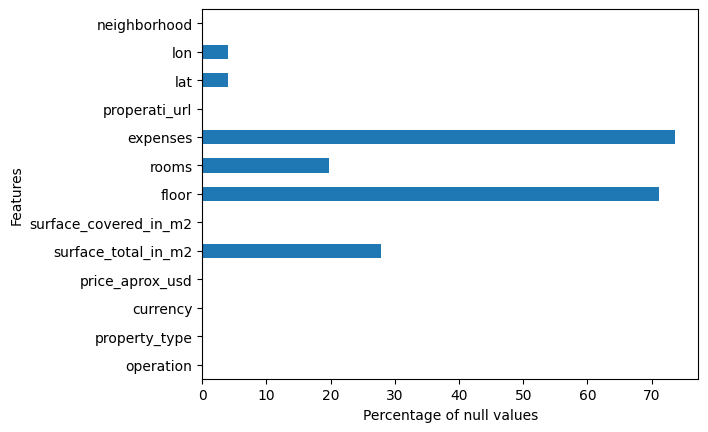

In [ ]:
#understanding null values
(df.isnull().sum()/len(df)*100).plot(kind = "barh")
plt.xlabel("Percentage of null values")
plt.ylabel("Features");

#printing all the columns with null count percentage>50
print("The columns needed to be dropped are:", df.columns[(df.isnull().sum()/len(df)*100) > 50]);

In [ ]:
#low and high cardinality categorical variables
print(df.select_dtypes("object").nunique())

df.select_dtypes("object").head()

operation           1
property_type       1
currency            2
expenses          354
properati_url    6582
neighborhood       57
dtype: int64


,operation,property_type,currency,expenses,properati_url,neighborhood
4,sell,apartment,USD,NaN,http://chacarita.properati.com.ar/10qlv_venta_...,Chacarita
9,sell,apartment,USD,NaN,http://villa-luro.properati.com.ar/12m82_venta...,Villa Luro
29,sell,apartment,USD,NaN,http://caballito.properati.com.ar/11wqh_venta_...,Caballito
40,sell,apartment,USD,364,http://constitucion.properati.com.ar/k2f0_vent...,Constitución
41,sell,apartment,USD,450,http://once.properati.com.ar/suwa_venta_depart...,Once


In [ ]:
sorted(df.columns)
#leaky features:
#price
#price per sq meter

['currency',
 'expenses',
 'floor',
 'lat',
 'lon',
 'neighborhood',
 'operation',
 'price_aprox_usd',
 'properati_url',
 'property_type',
 'rooms',
 'surface_covered_in_m2',
 'surface_total_in_m2']

In [ ]:
["price", "price_aprox_local_currency", "price_per_m2", "price_usd_per_m2"]

['price', 'price_aprox_local_currency', 'price_per_m2', 'price_usd_per_m2']

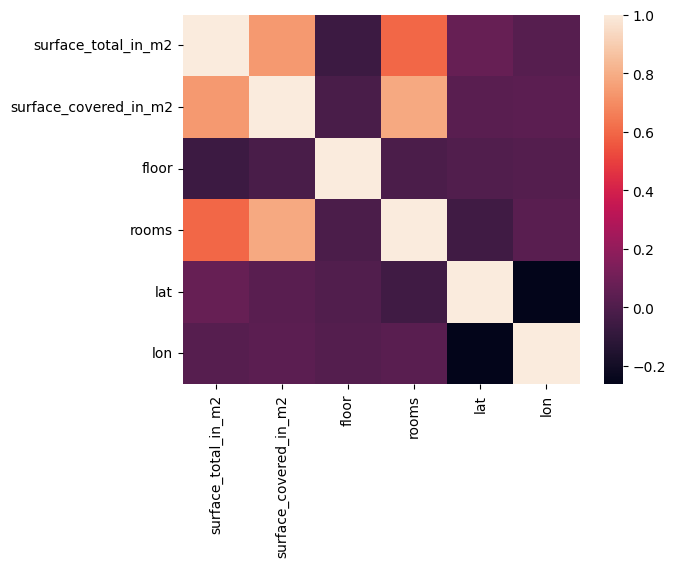

In [ ]:
#Multi collinearity
#plotting a multicollinearity heatmap
corr_matrix = df.select_dtypes("number").drop(["price_aprox_usd"],axis = 1).corr()
sns.heatmap(corr_matrix);

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6582 entries, 4 to 8597
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   operation              6582 non-null   object 
 1   property_type          6582 non-null   object 
 2   currency               6582 non-null   object 
 3   price_aprox_usd        6582 non-null   float64
 4   surface_total_in_m2    4752 non-null   float64
 5   surface_covered_in_m2  6582 non-null   float64
 6   floor                  1900 non-null   float64
 7   rooms                  5286 non-null   float64
 8   expenses               1739 non-null   object 
 9   properati_url          6582 non-null   object 
 10  lat                    6316 non-null   float64
 11  lon                    6316 non-null   float64
 12  neighborhood           6582 non-null   object 
dtypes: float64(7), object(6)
memory usage: 719.9+ KB


In [ ]:
target = "price_aprox_usd"
y_train = df[target]
print("shape of y_train:", y_train.shape)
X_train = df.drop(["price_aprox_usd"], axis = 1)
#X_train = X_train.reset_index()
#X_train = X_train.drop(["index"], axis = 1)
#X_train.head()

shape of y_train: (6582,)


In [ ]:
#Model building
y_mean = y_train.mean()
print("Mean price:", round(y_mean,2))
y_pred_baseline = [y_mean] * len(y_train)
print("y_pred_baseline looks like: ",y_pred_baseline[:2])

#mean absolute error baseline
mae_baseline = mean_absolute_error(y_train,y_pred_baseline)
print("The baseline Mean Absolute Error:", round(mae_baseline,2))

Mean price: 132383.84
y_pred_baseline looks like:  [np.float64(132383.83701458524), np.float64(132383.83701458524)]
The baseline Mean Absolute Error: 44860.11


In [ ]:
model = make_pipeline(
    OneHotEncoder(handle_unknown='ignore'),
    SimpleImputer(),
    Ridge()
)
model.fit(X_train,y_train)
check_is_fitted(model[-1])

In [ ]:
y_pred_training = model.predict(X_train)
mae_train = mean_absolute_error(y_train,y_pred_training)
print("Training MAE:",mae_train)

X_train

Training MAE: 9572.542492595732


,surface_covered_in_m2,lat,lon,neighborhood
4,70.0,-34.584651,-58.454693,Chacarita
9,42.0,-34.638979,-58.500115,Villa Luro
29,54.0,-34.615847,-58.459957,Caballito
40,42.0,-34.625222,-58.382382,Constitución
41,50.0,-34.610610,-58.412511,Once
...,...,...,...,...
8566,83.0,-34.639528,-58.519666,Liniers
8573,45.0,-34.597825,-58.416439,Palermo
8577,42.0,-34.652233,-58.490739,Mataderos
8578,48.0,-34.648761,-58.500180,Mataderos


In [ ]:
def make_prediction(area, lat, lon, neighborhood):
  data ={
      "surface_covered_in_m2": area,
      "lat": lat,
      "lon": lon,
      "neighborhood": neighborhood
  }
  df = pd.DataFrame(data, index =[0])
  prediction = round(model.predict(df)[0],2)

  pred = {
      "Price": prediction,
  }
  pd.DataFrame(pred,index=[0]).plot(kind = 'bar')

  return f"The price of the appartment should be around ${prediction}"


In [ ]:
l = interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    neighborhood=Dropdown(options=sorted(X_train["neighborhood"].unique())),
);

interactive(children=(IntSlider(value=53, description='area', max=101, min=30), FloatSlider(value=-34.59890626…